In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS   = 3    # RGB
EPOCHS     = 5   # no. iterations to train the model

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    
    r"C:\Users\Pooja Sharma\Documents\Orchid_Plant\Data",   # images path
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6500 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['cattleya', 'dendrobium', 'oncidium', 'phalaenopsis', 'vanda']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 0 1 3 4 1 2 2 2 0 4 0 0 4 3 4 1 4 1 2 3 1 1 2 0 3 1 3 0 3 2 4]


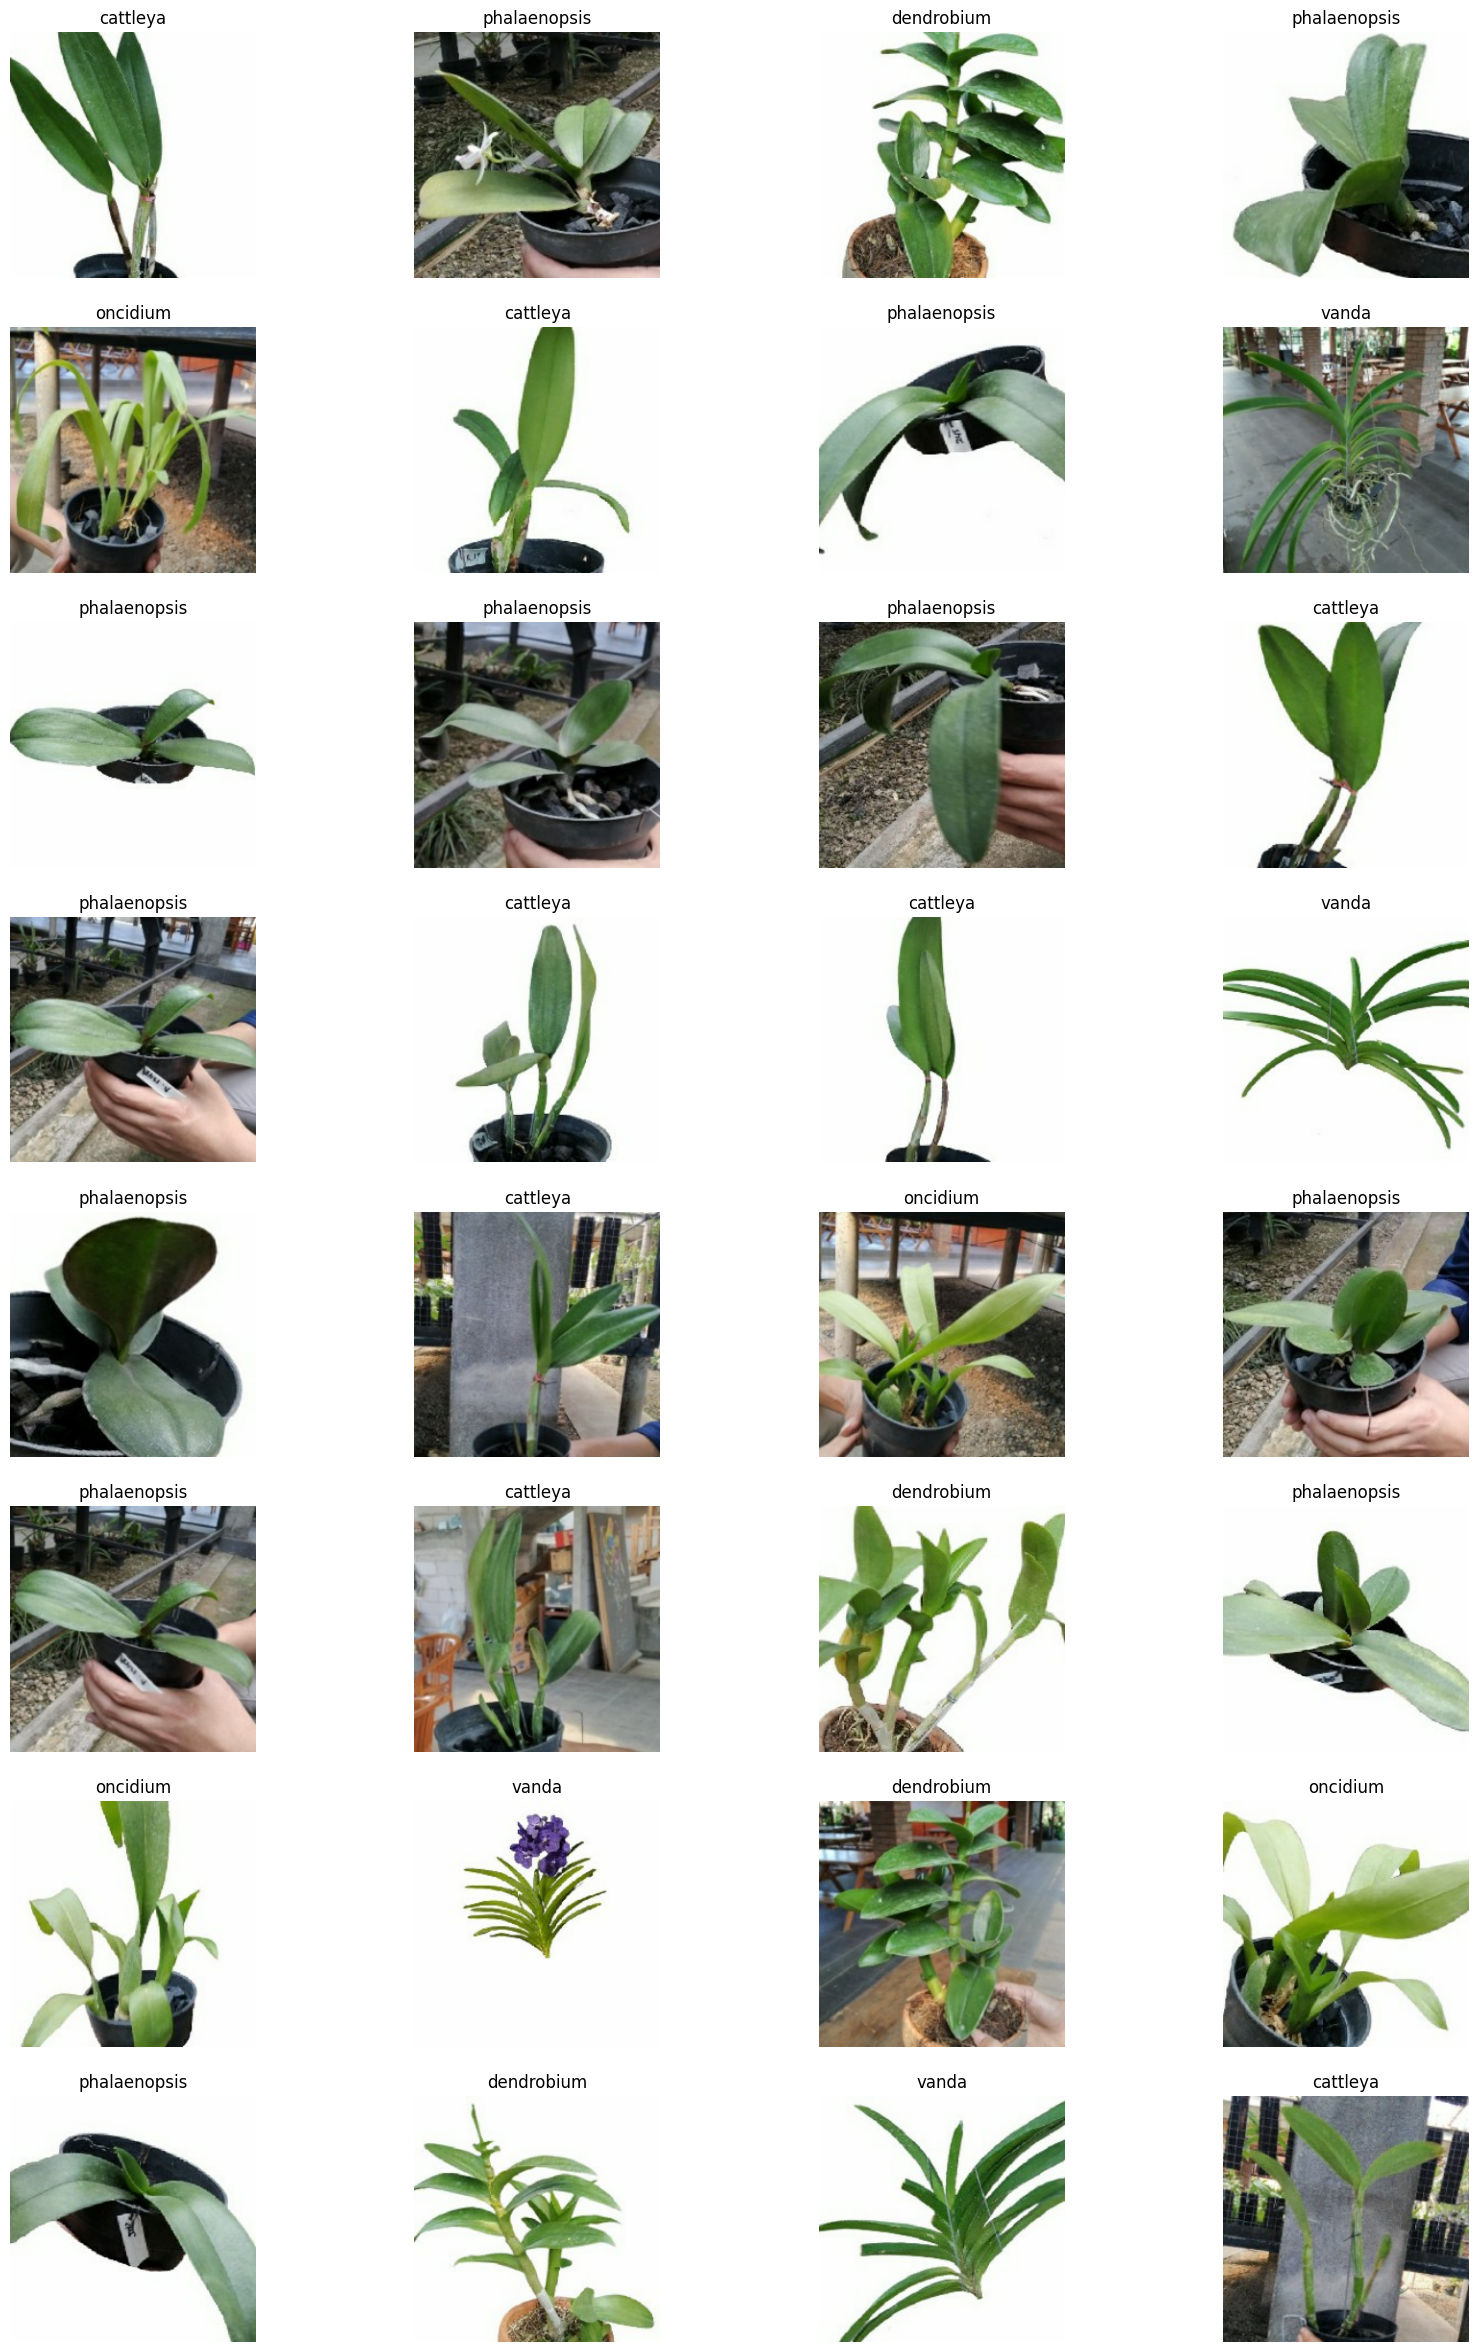

In [6]:
plt.figure(figsize=(20, 30))
for image_batch, label_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(BATCH_SIZE//4, 4, i + 1)   # row, col, idx
        plt.imshow(image_batch[i].numpy().astype("uint8"))   # converting float to int
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
split_dataset = get_dataset_partitions_tf(dataset)

# print length of each set (in batch)

print("Total:", len(dataset))

for m, n in zip(("Train:", "Valid:", "Test: "), split_dataset):
    print(m, len(n))

Total: 204
Train: 163
Valid: 20
Test:  21


In [9]:
train_ds, val_ds, test_ds = (ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) for ds in split_dataset)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
#     data_augmentation,
    
    # layering
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # flatten
    layers.Flatten(),
    
    # dense layer
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/5
163/163 [==============================] - 1381s 7s/step - loss: 0.8629 - accuracy: 0.6305 - val_loss: 0.2513 - val_accuracy: 0.9281
Epoch 2/5
163/163 [==============================] - 708s 4s/step - loss: 0.2157 - accuracy: 0.9372 - val_loss: 0.1608 - val_accuracy: 0.9453
Epoch 3/5
163/163 [==============================] - 729s 4s/step - loss: 0.1577 - accuracy: 0.9520 - val_loss: 0.0886 - val_accuracy: 0.9672
Epoch 4/5
163/163 [==============================] - 714s 4s/step - loss: 0.0934 - accuracy: 0.9697 - val_loss: 0.0546 - val_accuracy: 0.9766
Epoch 5/5
163/163 [==============================] - 766s 5s/step - loss: 0.0549 - accuracy: 0.9850 - val_loss: 0.0287 - val_accuracy: 0.9875


In [16]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 764s 3s/step - loss: 0.0239 - accuracy: 0.9911


In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

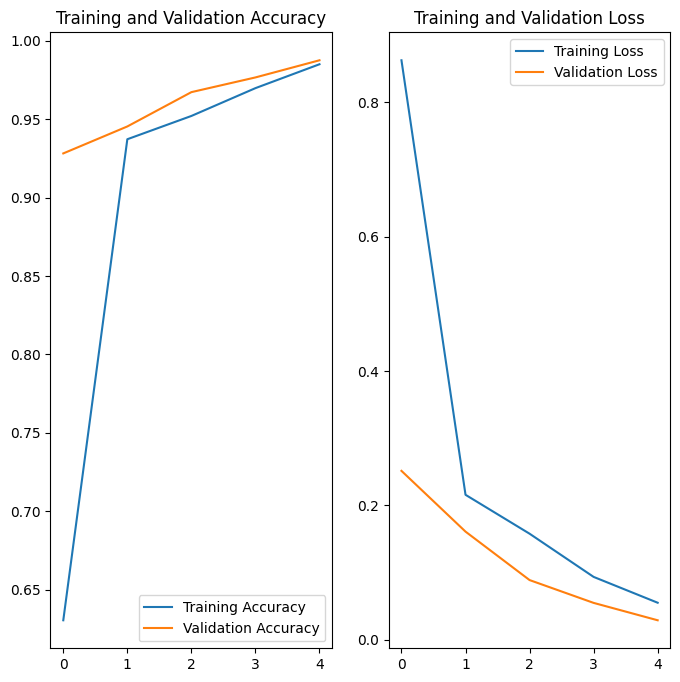

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 15s 15s/step


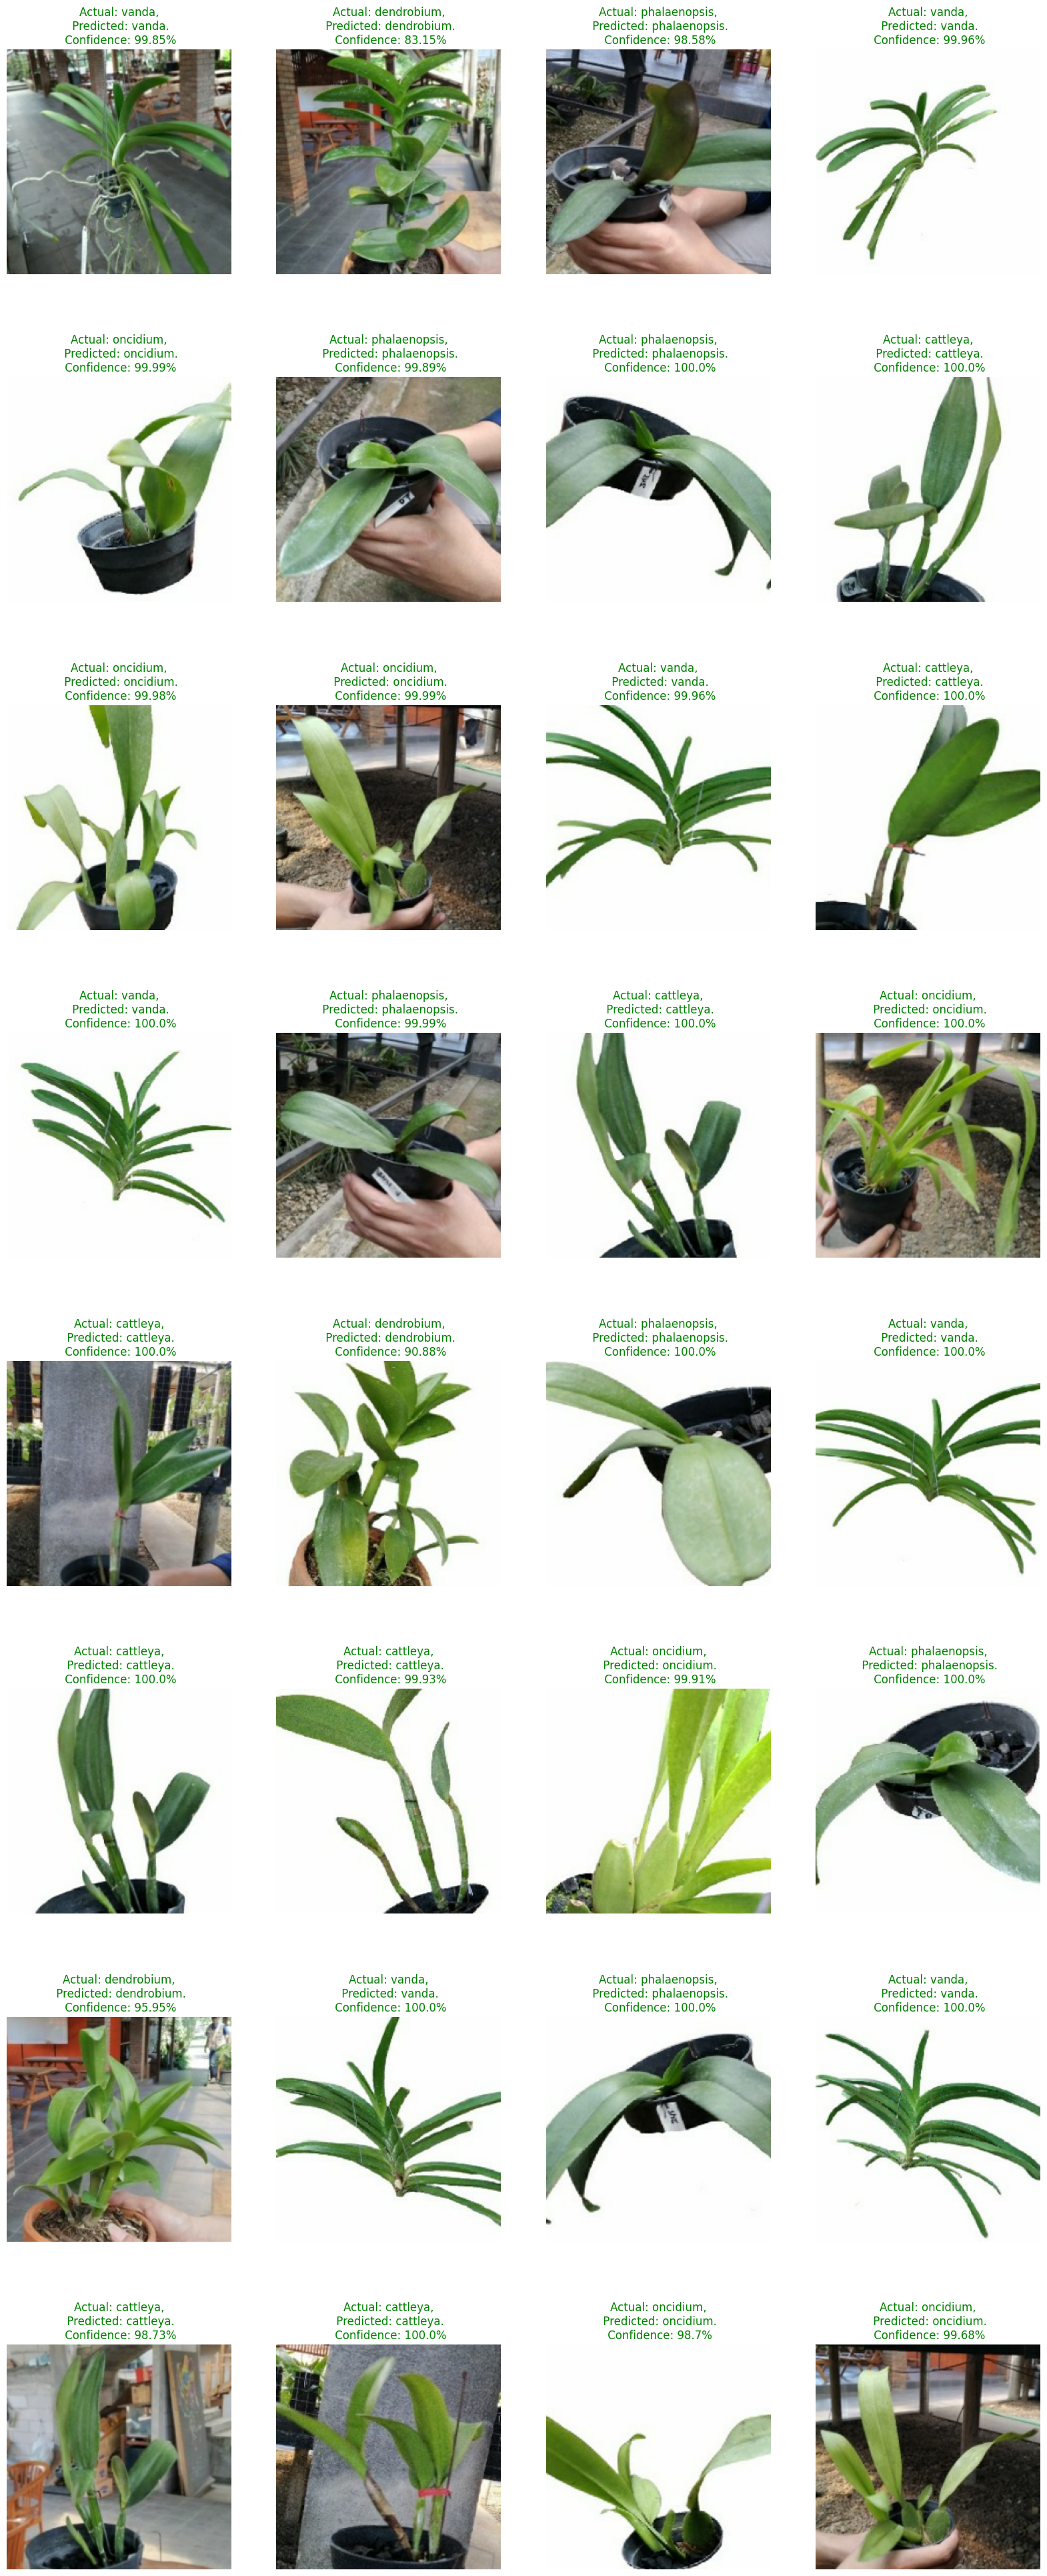

In [19]:
import numpy as np

plt.figure(figsize=(20, 50))
for image_batch, label_batch in test_ds.take(1):
    
    prediction_batch = model.predict(image_batch)   # contains array of size len(class_names) with confidence
    
    for i in range(BATCH_SIZE):
        
        image = image_batch[i].numpy().astype("uint8")   # converting float to int
        
        actual_class    = class_names[label_batch[i]]
        predicted_class = class_names[np.argmax(prediction_batch[i])]
        confidence      = round(100 * (np.max(prediction_batch[i])), 2)
        
        ax = plt.subplot(BATCH_SIZE//4, 4, i + 1)   # row, col, idx
        plt.imshow(image)
        title = plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.setp(title, color= 'g' if actual_class == predicted_class else 'r')
        plt.axis("off")

In [20]:
model.save('model.hdf5')

C:\Users\Pooja Sharma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
